## Transient Lightcurve Explorer

This notebook allows you to interactively explore transient lightcurves from the SNANA simulation data
and select specific ones for symbolic regression.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import display
import ipywidgets as widgets

### Data Loading

In [4]:
# Create output directories
os.makedirs("selected_lightcurves", exist_ok=True)
# Load the dataset
data_path = "/Users/pablocornejo/Documents/Tesis/snana_processing/data/sim_samples.npz"
data = np.load(data_path, allow_pickle=True)

# Display available transient types
print("Available transient types:")
print("-" * 30)
for key in data:
    print(f"{key}: {len(data[key])} samples")

# Define model types of interest
model_types = ["SNIa-SALT2", "SNIc-Templates", "SLSN-I+host", "TDE", 
               "KN_K17", "ILOT", "PISN-MOSFIT", "SNIax"]

# Filter to only include available types
available_types = [model for model in model_types if model in data and len(data[model]) > 0]

Available transient types:
------------------------------
CART: 1000 samples
SNIIn+HostXT_V19: 1000 samples
dwarf-nova: 300 samples
AGN: 145 samples
SNII-Templates: 1000 samples
uLens-Binary: 378 samples
SNIa-SALT2: 1000 samples
SNIax: 5 samples
d-Sct: 462 samples
KN_K17: 1000 samples
Mdwarf-flare: 304 samples
RRL: 6 samples
PISN-STELLA_HECORE: 10 samples
uLens-Single_PyLIMA: 291 samples
uLens-Single-GenLens: 349 samples
SNIIb+HostXT_V19: 1000 samples
SNIb-Templates: 1000 samples
SNIc-Templates: 1000 samples
TDE: 1000 samples
PISN-STELLA_HYDROGENIC: 1000 samples
SNIc+HostXT_V19: 1000 samples
EB: 81 samples
SNIa-91bg: 1000 samples
SNIcBL+HostXT_V19: 1000 samples
Cepheid: 44 samples
SNIIn-MOSFIT: 132 samples
SLSN-I+host: 1000 samples
SNIb+HostXT_V19: 1000 samples
SLSN-I_no_host: 56 samples
SNII-NMF: 1000 samples
ILOT: 192 samples
PISN-MOSFIT: 1000 samples
SNII+HostXT_V19: 2 samples
KN_B19: 1000 samples


### Helper Functions

In [ ]:
def extract_and_examine_sample(model_name, sample_id):
    """Examine the raw sample data"""
    sample = data[model_name][sample_id]
    df = pd.DataFrame(sample)
    
    # Print basic info
    print(f"Sample shape: {sample.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Count observations by PHOTFLAG
    print("\nPHOTFLAG counts:")
    photflag_counts = df['PHOTFLAG'].value_counts()
    for flag, count in photflag_counts.items():
        print(f"  PHOTFLAG {flag}: {count} observations")
    
    # Check time range
    print(f"\nTime (MJD) range: {df['MJD'].min()} to {df['MJD'].max()}")
    
    # Check bands
    bands = np.unique(df['BAND'])
    print(f"\nUnique bands ({len(bands)}): {bands}")
    
    # Count observations per band
    print("\nObservations per band:")
    for band in bands:
        band_count = len(df[df['BAND'] == band])
        band_label = band.decode('utf-8') if isinstance(band, bytes) else band
        print(f"  Band {band_label}: {band_count} observations")
    
    return df

# %%
def extract_lightcurve(sample, filter_by_photflag=True, min_points_per_band=5):
    """Extract lightcurve data by band from a sample."""
    # Convert to DataFrame
    df = pd.DataFrame(sample)
    
    # Get unique bands
    bands = np.unique(df['BAND'])
    
    # Create a dictionary to store data for each band
    band_curves = {}
    
    for band in bands:
        # Filter by band
        band_data = df[df['BAND'] == band]
        
        # Filter by PHOTFLAG if requested (0 = good observation)
        if filter_by_photflag:
            good_data = band_data[band_data['PHOTFLAG'] == 0]
        else:
            good_data = band_data
        
        # Skip if not enough data points
        if len(good_data) < min_points_per_band:
            continue
            
        # Sort by time
        good_data = good_data.sort_values('MJD')
        
        # Extract data
        band_label = band.decode('utf-8') if isinstance(band, bytes) else band
        
        # Create DataFrame with relevant columns
        band_curves[band_label] = pd.DataFrame({
            'MJD': good_data['MJD'].values,
            'FLUXCAL': good_data['FLUXCAL'].values,
            'FLUXCALERR': good_data['FLUXCALERR'].values,
            'PHOTFLAG': good_data['PHOTFLAG'].values
        })
    
    return band_curves

# %%
def plot_lightcurve(band_curves, model_name, sample_id, title=None):
    """Plot the lightcurve data for all bands."""
    if not band_curves:
        print("No valid band curves to plot.")
        return
        
    plt.figure(figsize=(14, 7))
    
    for band_name, band_data in band_curves.items():
        plt.errorbar(
            band_data['MJD'], 
            band_data['FLUXCAL'], 
            yerr=band_data['FLUXCALERR'],
            fmt='o-', 
            label=f'Band {band_name}'
        )
    
    # Set title
    if title:
        plt.title(title)
    else:
        plt.title(f"{model_name} - Sample {sample_id}")
    
    # Add context information
    min_mjd = min([band_data['MJD'].min() for band_data in band_curves.values()])
    max_mjd = max([band_data['MJD'].max() for band_data in band_curves.values()])
    span = max_mjd - min_mjd
    
    # Add annotation with MJD range
    plt.annotate(f"MJD range: {min_mjd:.1f} to {max_mjd:.1f} (span: {span:.1f} days)",
                xy=(0.02, 0.02), xycoords='figure fraction', 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.xlabel("Time (MJD)")
    plt.ylabel("Flux")
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout()
    
    plt.show()

# %%
def save_selected_lightcurve(band_curves, model_name, sample_id):
    """Save the selected lightcurve for symbolic regression."""
    # Create directory
    os.makedirs(f"selected_lightcurves/{model_name}", exist_ok=True)
    
    saved_files = []
    
    for band_name, band_data in band_curves.items():
        # Normalize time to start at 0
        time = band_data['MJD'].values
        time_normalized = time - time.min()
        
        # Create output DataFrame
        df_out = pd.DataFrame({
            'time': time_normalized,
            'flux': band_data['FLUXCAL'].values,
            'flux_err': band_data['FLUXCALERR'].values,
            'original_time': time
        })
        
        # Save as CSV
        output_file = f"selected_lightcurves/{model_name}/sample_{sample_id}_band_{band_name}.csv"
        df_out.to_csv(output_file, index=False)
        saved_files.append(output_file)
    
    print(f"Saved {len(saved_files)} band curves to:")
    for file in saved_files:
        print(f"  - {file}")
    
    return saved_files

### Interactive Lightcurve Explorer

Examining SNIa-SALT2 sample 380:
--------------------------------------------------
Sample shape: (240,)
Columns: ['MJD', 'BAND', 'CCDNUM', 'FIELD', 'PHOTFLAG', 'PHOTPROB', 'FLUXCAL', 'FLUXCALERR', 'PSF_SIG1', 'PSF_SIG2', 'PSF_RATIO', 'SKY_SIG', 'SKY_SIG_T', 'RDNOISE', 'ZEROPT', 'ZEROPT_ERR', 'GAIN', 'XPIX', 'YPIX', 'SIM_FLUXCAL_HOSTERR', 'SIM_MAGOBS']

PHOTFLAG counts:
  PHOTFLAG 4096: 209 observations
  PHOTFLAG 0: 31 observations

Time (MJD) range: 53000.0 to 53478.0

Unique bands (1): [b'i ']

Observations per band:
  Band i : 240 observations

Data points per band after filtering:
  Band i : 240 points


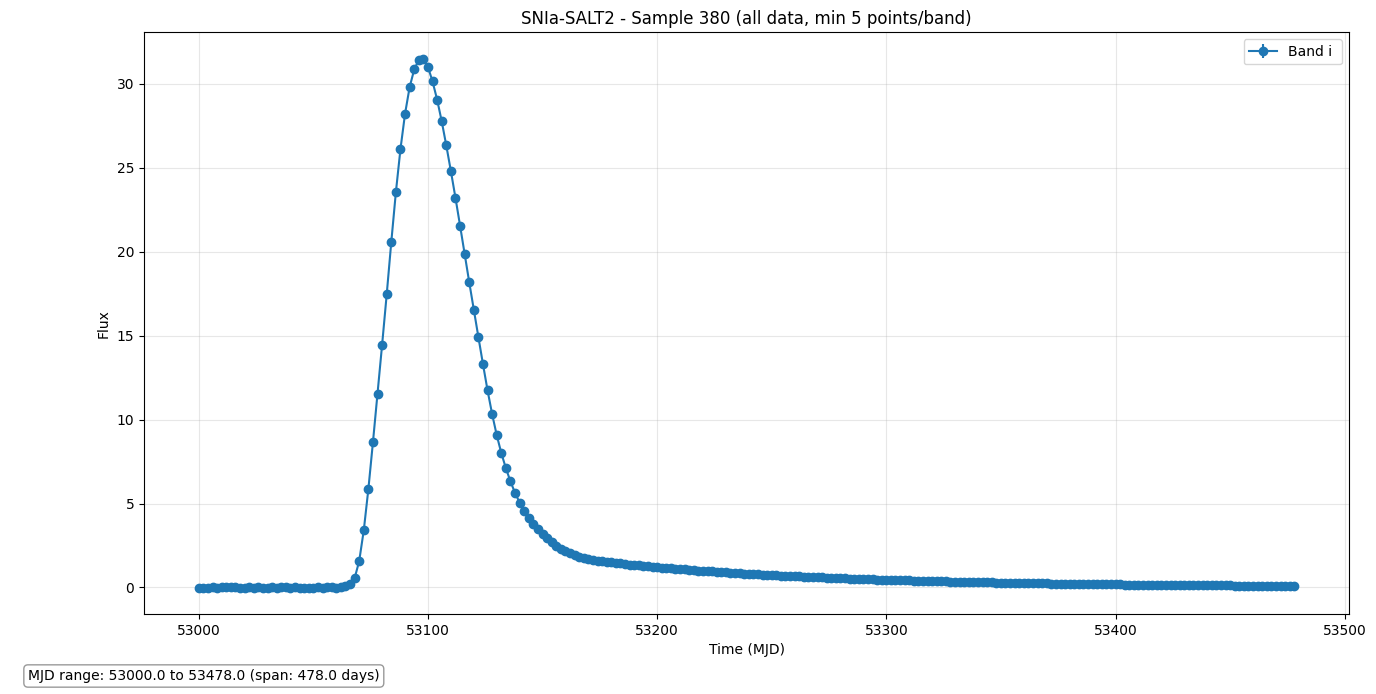

Saved 1 band curves to:
  - selected_lightcurves/SNIa-SALT2/sample_380_band_i .csv
Examining KN_K17 sample 0:
--------------------------------------------------
Sample shape: (240,)
Columns: ['MJD', 'BAND', 'CCDNUM', 'FIELD', 'PHOTFLAG', 'PHOTPROB', 'FLUXCAL', 'FLUXCALERR', 'PSF_SIG1', 'PSF_SIG2', 'PSF_RATIO', 'SKY_SIG', 'SKY_SIG_T', 'RDNOISE', 'ZEROPT', 'ZEROPT_ERR', 'GAIN', 'XPIX', 'YPIX', 'SIM_FLUXCAL_HOSTERR', 'SIM_MAGOBS']

PHOTFLAG counts:
  PHOTFLAG 0: 234 observations
  PHOTFLAG 4096: 6 observations

Time (MJD) range: 53000.0 to 53478.0

Unique bands (1): [b'i ']

Observations per band:
  Band i : 240 observations

Data points per band after filtering:
  Band i : 240 points


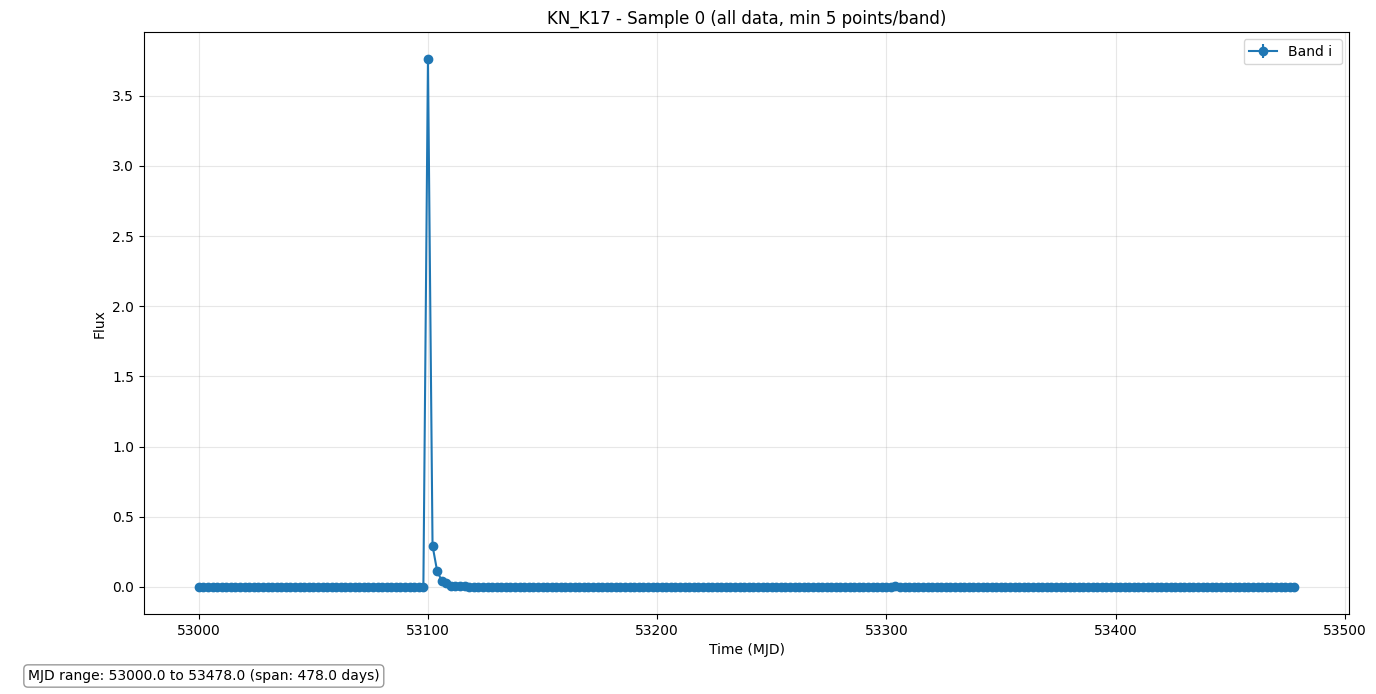

Examining PISN-MOSFIT sample 0:
--------------------------------------------------
Sample shape: (240,)
Columns: ['MJD', 'BAND', 'CCDNUM', 'FIELD', 'PHOTFLAG', 'PHOTPROB', 'FLUXCAL', 'FLUXCALERR', 'PSF_SIG1', 'PSF_SIG2', 'PSF_RATIO', 'SKY_SIG', 'SKY_SIG_T', 'RDNOISE', 'ZEROPT', 'ZEROPT_ERR', 'GAIN', 'XPIX', 'YPIX', 'SIM_FLUXCAL_HOSTERR', 'SIM_MAGOBS']

PHOTFLAG counts:
  PHOTFLAG 4096: 188 observations
  PHOTFLAG 0: 52 observations

Time (MJD) range: 53000.0 to 53478.0

Unique bands (1): [b'i ']

Observations per band:
  Band i : 240 observations

Data points per band after filtering:
  Band i : 240 points


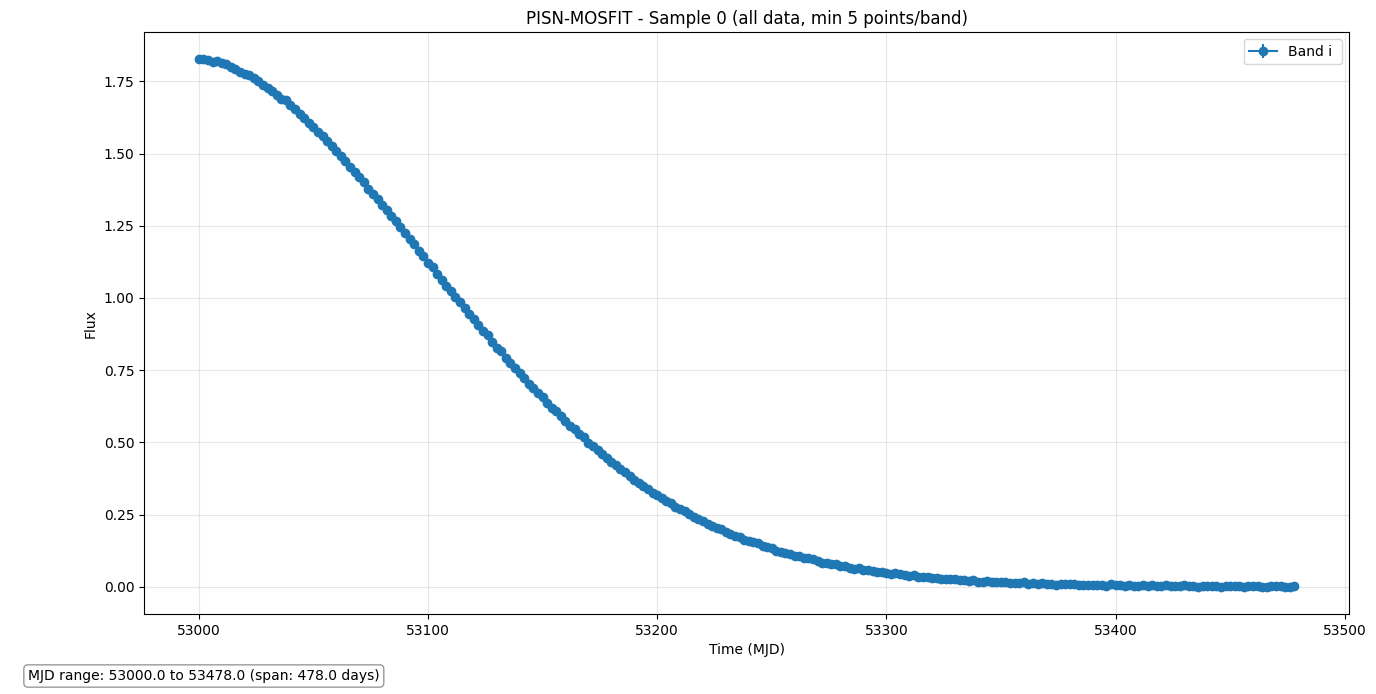

In [21]:
# Create dropdown for model selection
model_dropdown = widgets.Dropdown(
    options=available_types,
    description='Model Type:',
    disabled=False,
)

# Function to update sample slider when model changes
def update_sample_slider(change):
    model = change['new']
    num_samples = len(data[model])
    sample_slider.max = num_samples - 1
    sample_slider.value = 0
    
model_dropdown.observe(update_sample_slider, names='value')

# Create slider for sample selection
sample_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(data[available_types[0]]) - 1 if available_types else 0,
    step=1,
    description='Sample ID:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

# Checkbox for PHOTFLAG filtering
photflag_checkbox = widgets.Checkbox(
    value=True,
    description='Filter by PHOTFLAG=0',
    disabled=False,
    indent=False
)

# Slider for minimum points per band
min_points_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=20,
    step=1,
    description='Min. points:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

# Function to display the selected lightcurve
def display_lightcurve(model, sample_id, filter_by_photflag, min_points):
    sample = data[model][sample_id]
    
    # First examine the sample
    print(f"Examining {model} sample {sample_id}:")
    print("-" * 50)
    raw_df = extract_and_examine_sample(model, sample_id)
    
    # Then extract the lightcurve
    band_curves = extract_lightcurve(
        sample, 
        filter_by_photflag=filter_by_photflag,
        min_points_per_band=min_points
    )
    
    # Show counts of points after filtering
    if band_curves:
        print("\nData points per band after filtering:")
        for band, curve in band_curves.items():
            print(f"  Band {band}: {len(curve)} points")
        
        # Create a descriptive title
        if filter_by_photflag:
            title = f"{model} - Sample {sample_id} (PHOTFLAG=0 only, min {min_points} points/band)"
        else:
            title = f"{model} - Sample {sample_id} (all data, min {min_points} points/band)"
            
        plot_lightcurve(band_curves, model, sample_id, title=title)
    else:
        print("\nNo valid lightcurve data found after applying filters.")
    
    return band_curves

# Button to display the selected lightcurve
display_button = widgets.Button(
    description='Display Lightcurve',
    disabled=False,
    button_style='info',
    tooltip='Click to display the selected lightcurve'
)

def on_display_button_clicked(b):
    global current_band_curves
    current_band_curves = display_lightcurve(
        model_dropdown.value, 
        sample_slider.value,
        photflag_checkbox.value,
        min_points_slider.value
    )
    
display_button.on_click(on_display_button_clicked)

# Button to save the selected lightcurve
save_button = widgets.Button(
    description='Save Selected',
    disabled=False,
    button_style='success',
    tooltip='Save the selected lightcurve for symbolic regression'
)

def on_save_button_clicked(b):
    if 'current_band_curves' in globals() and current_band_curves:
        save_selected_lightcurve(current_band_curves, model_dropdown.value, sample_slider.value)
    else:
        print("No lightcurve has been displayed yet. Click 'Display Lightcurve' first.")
        
save_button.on_click(on_save_button_clicked)

# Display widgets
display(widgets.VBox([
    model_dropdown,
    sample_slider,
    widgets.HBox([photflag_checkbox, min_points_slider]),
    widgets.HBox([display_button, save_button])
]))

Button(button_style='warning', description='Examine Raw Data', style=ButtonStyle(), tooltip='Examine the raw d…

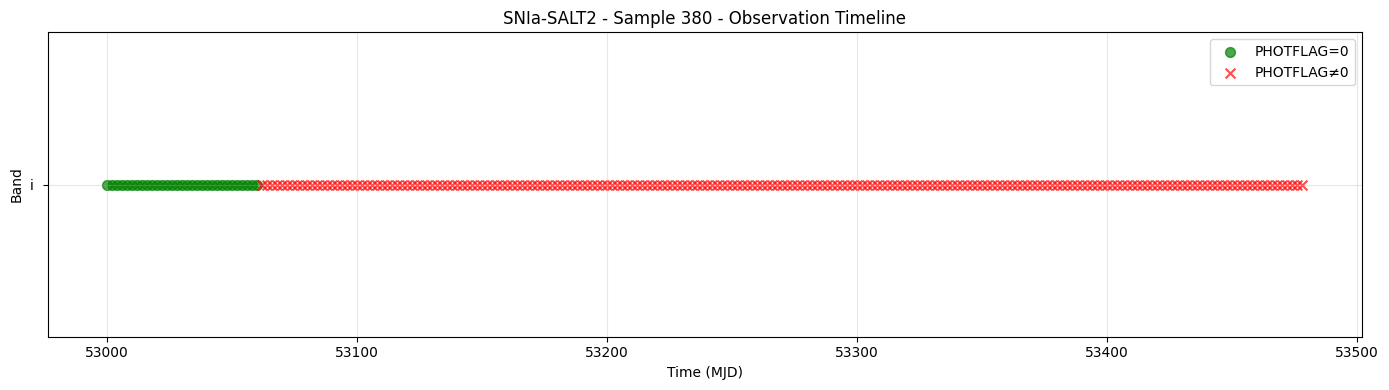

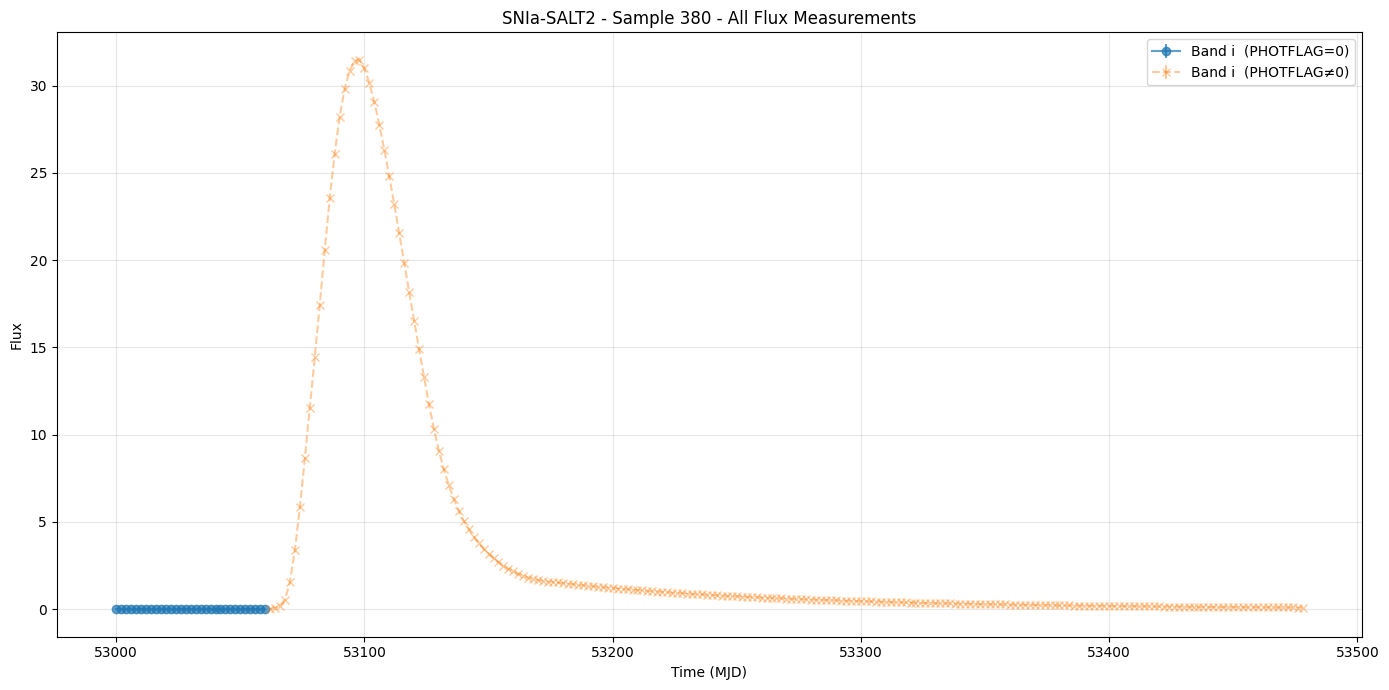


Raw data sample (first 10 rows):


,MJD,BAND,CCDNUM,FIELD,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,PSF_SIG1,PSF_SIG2,...,SKY_SIG,SKY_SIG_T,RDNOISE,ZEROPT,ZEROPT_ERR,GAIN,XPIX,YPIX,SIM_FLUXCAL_HOSTERR,SIM_MAGOBS
0,53000.0,b'i ',-9,b'VOID ',0,-9.0,-0.002158,0.001418,1.0,0.0,...,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0
1,53002.0,b'i ',-9,b'VOID ',0,-9.0,-0.002495,0.001418,1.0,0.0,...,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0
2,53004.0,b'i ',-9,b'VOID ',0,-9.0,-0.002230,0.001418,1.0,0.0,...,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0
3,53006.0,b'i ',-9,b'VOID ',0,-9.0,0.001904,0.001418,1.0,0.0,...,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0
4,53008.0,b'i ',-9,b'VOID ',0,-9.0,-0.000429,0.001418,1.0,0.0,...,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0
5,53010.0,b'i ',-9,b'VOID ',0,-9.0,-0.000238,0.001418,1.0,0.0,...,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0
6,53012.0,b'i ',-9,b'VOID ',0,-9.0,0.000453,0.001418,1.0,0.0,...,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0
7,53014.0,b'i ',-9,b'VOID ',0,-9.0,0.002164,0.001418,1.0,0.0,...,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0
8,53016.0,b'i ',-9,b'VOID ',0,-9.0,0.002175,0.001418,1.0,0.0,...,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0
9,53018.0,b'i ',-9,b'VOID ',0,-9.0,-0.000768,0.001418,1.0,0.0,...,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0


In [22]:
def examine_raw_sample_data():
    """Examine the raw data of the currently selected sample"""
    model = model_dropdown.value
    sample_id = sample_slider.value
    
    # Get the sample
    sample = data[model][sample_id]
    df = pd.DataFrame(sample)
    
    # Display all observation times
    plt.figure(figsize=(14, 4))
    bands = np.unique(df['BAND'])
    
    for band in bands:
        band_label = band.decode('utf-8') if isinstance(band, bytes) else band
        band_data = df[df['BAND'] == band]
        
        # Plot all points, color by PHOTFLAG
        good_obs = band_data[band_data['PHOTFLAG'] == 0]
        bad_obs = band_data[band_data['PHOTFLAG'] != 0]
        
        if len(good_obs) > 0:
            plt.scatter(good_obs['MJD'], [band_label] * len(good_obs), 
                      marker='o', s=50, alpha=0.7, color='green', label='PHOTFLAG=0')
        
        if len(bad_obs) > 0:
            plt.scatter(bad_obs['MJD'], [band_label] * len(bad_obs), 
                      marker='x', s=50, alpha=0.7, color='red', label='PHOTFLAG≠0')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.title(f"{model} - Sample {sample_id} - Observation Timeline")
    plt.xlabel("Time (MJD)")
    plt.ylabel("Band")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Now plot the flux values
    plt.figure(figsize=(14, 7))
    
    for band in bands:
        band_label = band.decode('utf-8') if isinstance(band, bytes) else band
        band_data = df[df['BAND'] == band]
        
        # Sort by time
        band_data = band_data.sort_values('MJD')
        
        # Plot with different markers for different PHOTFLAG values
        good_obs = band_data[band_data['PHOTFLAG'] == 0]
        bad_obs = band_data[band_data['PHOTFLAG'] != 0]
        
        if len(good_obs) > 0:
            plt.errorbar(good_obs['MJD'], good_obs['FLUXCAL'], yerr=good_obs['FLUXCALERR'],
                       fmt='o-', alpha=0.7, label=f'Band {band_label} (PHOTFLAG=0)')
        
        if len(bad_obs) > 0:
            plt.errorbar(bad_obs['MJD'], bad_obs['FLUXCAL'], yerr=bad_obs['FLUXCALERR'],
                       fmt='x--', alpha=0.4, label=f'Band {band_label} (PHOTFLAG≠0)')
    
    plt.title(f"{model} - Sample {sample_id} - All Flux Measurements")
    plt.xlabel("Time (MJD)")
    plt.ylabel("Flux")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Display the raw data
    return df

# Button to examine raw data
examine_raw_button = widgets.Button(
    description='Examine Raw Data',
    disabled=False,
    button_style='warning',
    tooltip='Examine the raw data of the current sample'
)

def on_examine_raw_button_clicked(b):
    global raw_df
    raw_df = examine_raw_sample_data()
    print("\nRaw data sample (first 10 rows):")
    display(raw_df.head(10))
    
examine_raw_button.on_click(on_examine_raw_button_clicked)

# Display the button
display(examine_raw_button)

In [19]:
def prepare_for_symbolic_regression(normalize=True, smooth=False, spline_s=0.1):
    """Prepare selected lightcurves for symbolic regression."""
    from scipy.interpolate import UnivariateSpline
    from sklearn.preprocessing import MinMaxScaler
    
    # Create output directories
    os.makedirs("symbolic_regression_data", exist_ok=True)
    os.makedirs("symbolic_regression_plots", exist_ok=True)
    
    # Get all selected lightcurve files
    selected_models = [d for d in os.listdir("selected_lightcurves") 
                      if os.path.isdir(os.path.join("selected_lightcurves", d))]
    
    for model in selected_models:
        print(f"Processing {model}...")
        os.makedirs(f"symbolic_regression_data/{model}", exist_ok=True)
        
        model_dir = os.path.join("selected_lightcurves", model)
        csv_files = [f for f in os.listdir(model_dir) if f.endswith('.csv')]
        
        for csv_file in csv_files:
            # Load data
            file_path = os.path.join(model_dir, csv_file)
            df = pd.read_csv(file_path)
            
            # Extract info from filename
            parts = os.path.splitext(csv_file)[0].split('_')
            sample_id = parts[1]
            band = '_'.join(parts[3:])
            
            # Extract data
            time = df['time'].values
            flux = df['flux'].values
            flux_err = df['flux_err'].values
            original_time = df['original_time'].values
            
            # Sort by time
            sort_idx = np.argsort(time)
            time = time[sort_idx]
            flux = flux[sort_idx]
            flux_err = flux_err[sort_idx]
            original_time = original_time[sort_idx]
            
            # Normalize flux if requested
            if normalize:
                scaler = MinMaxScaler()
                flux = scaler.fit_transform(flux.reshape(-1, 1)).flatten()
                
                # Scale errors proportionally
                flux_range = np.max(df['flux'].values) - np.min(df['flux'].values)
                if flux_range > 0:
                    flux_err = flux_err / flux_range
            
            # Smooth data if requested
            if smooth and len(time) > 3:
                try:
                    # Use inverse of error as weights
                    weights = 1.0 / (flux_err + 1e-10)
                    spline = UnivariateSpline(time, flux, w=weights, s=spline_s)
                    
                    # Generate smoothed flux
                    flux_smooth = spline(time)
                    
                    # Only use smoothed values if they're valid
                    if np.all(np.isfinite(flux_smooth)):
                        flux = flux_smooth
                except Exception as e:
                    print(f"  Warning: Smoothing failed for {csv_file}: {e}")
            
            # Create output DataFrame
            df_out = pd.DataFrame({
                'time': time,
                'flux': flux,
                'flux_err': flux_err,
                'original_time': original_time
            })
            
            # Save processed data
            output_file = f"symbolic_regression_data/{model}/{os.path.splitext(csv_file)[0]}_sr.csv"
            df_out.to_csv(output_file, index=False)
            
            # Plot original vs processed
            plt.figure(figsize=(10, 6))
            
            # Original data
            plt.errorbar(df['time'], df['flux'], yerr=df['flux_err'], 
                        fmt='o', alpha=0.5, color='gray', label='Original data')
            
            # Processed data
            plt.plot(time, flux, 'o-', color='blue', label='Processed for SR')
            
            plt.title(f"{model} - Sample {sample_id} - Band {band}")
            plt.xlabel("Time (days from first observation)")
            plt.ylabel("Flux")
            plt.grid(True, alpha=0.3)
            plt.legend()
            
            plot_file = f"symbolic_regression_plots/{model}_sample_{sample_id}_band_{band}_sr.png"
            plt.savefig(plot_file)
            plt.close()
        
        print(f"  Completed processing {len(csv_files)} files for {model}")
    
    print("\nAll selected lightcurves prepared for symbolic regression!")

In [25]:
prepare_for_symbolic_regression(normalize=False, smooth=False, spline_s=0.1) 

Processing SNIa-SALT2...
  Completed processing 1 files for SNIa-SALT2

All selected lightcurves prepared for symbolic regression!
